# PCA

In [54]:
# import PCA from sklearn
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns
from collections import Counter

In [55]:

# read the data
data = pd.read_parquet('data/processed_dataset.parquet')

data.dtypes.unique()
data = data.select_dtypes(include=['float64', 'int64'])

# standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


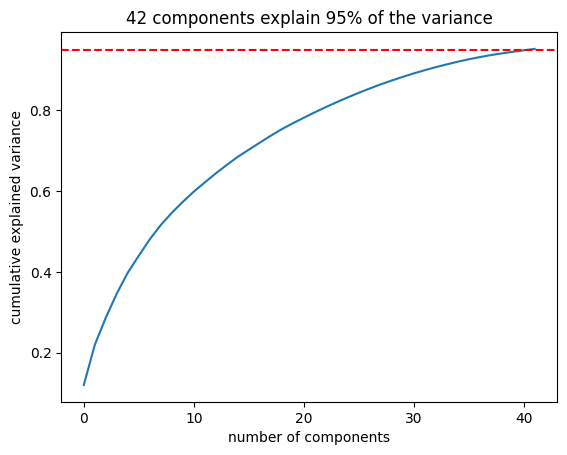

<Figure size 640x480 with 0 Axes>

In [50]:
pca = PCA(n_components=0.95)

# fit the data
pca.fit(data_scaled)

# transform the data
data_pca = pca.transform(data_scaled)

# plot the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title(f"{pca.n_components_} components explain 95% of the variance")
plt.show()

# save the plot
plt.savefig('images/explained_variance.png')


In [51]:
# now that we know we 42 components explain 95% of the variance lets apply some feature selection

# get the feature names
features = data.columns

# get the pca components
components = pca.components_

# get the most important features
most_important = [np.abs(components[i]).argmax() for i in range(pca.n_components_)]

# get the names of the most important features
most_important_names = [features[most_important[i]] for i in range(pca.n_components_)]



# Count the frequency of each feature being the most important
feature_counts = Counter(most_important_names)

# Convert to DataFrame for easier analysis
important_features_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency']).sort_values(by='Frequency', ascending=False)


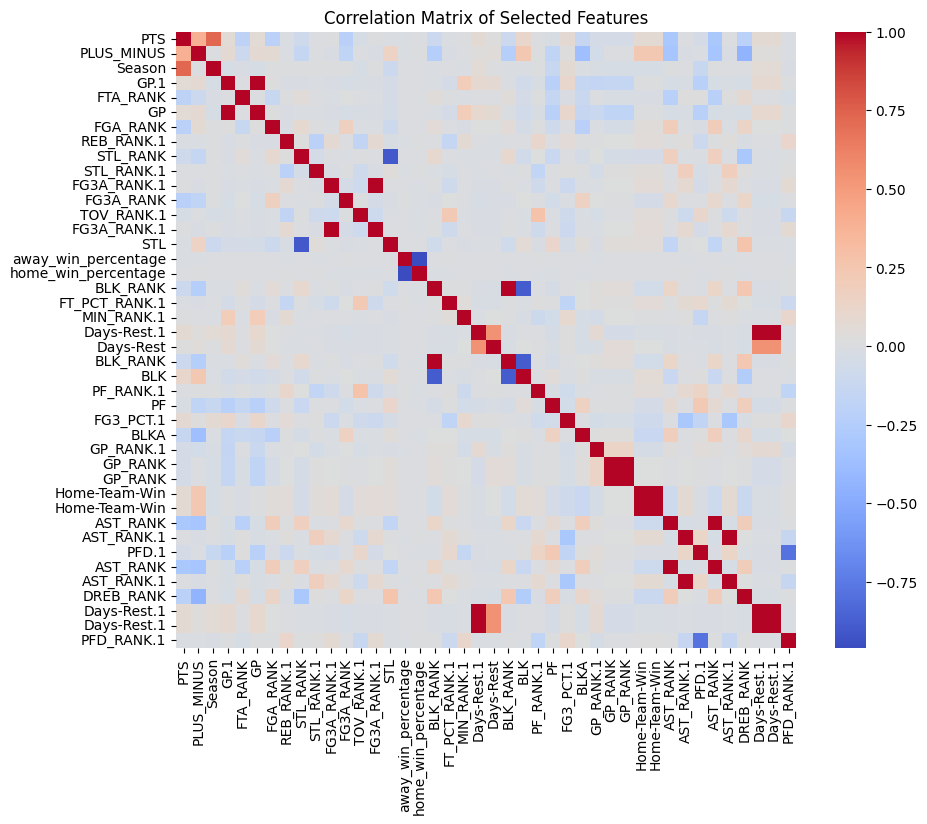

In [52]:
selected_features_PCA = data[most_important_names]
correlation_matrix = selected_features_PCA.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [53]:
# save the plot
plt.savefig('images/correlation_matrix.png')

# drop duplicates columns
selected_features_PCA = selected_features_PCA.loc[:,~selected_features_PCA.columns.duplicated()]


# save the selected features
selected_features_PCA.to_parquet('data/PCA_features.parquet')

<Figure size 640x480 with 0 Axes>

In [ ]:

# Perform feature selection
kbest_selector = SelectKBest(score_func=chi2, k=20)
data_selected_kbest = kbest_selector.fit_transform(selected_features_PCA, target)

# Get selected feature names
selected_kbest_features = selected_features_PCA.columns[kbest_selector.get_support()]
print("Selected Features with SelectKBest:", selected_kbest_features)

# Save the selected features
pd.DataFrame(data_selected_kbest, columns=selected_kbest_features).to_parquet('data/KBest_features.parquet')


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

# Initialize model
model = RandomForestClassifier()

# Sequential Forward Selection
sfs = SequentialFeatureSelector(model, n_features_to_select=20, direction='forward')
data_selected_sfs = sfs.fit_transform(selected_features_PCA, target)

# Get selected feature names
selected_sfs_features = selected_features_PCA.columns[sfs.get_support()]
print("Selected Features with SFS:", selected_sfs_features)

# Save the selected features
pd.DataFrame(data_selected_sfs, columns=selected_sfs_features).to_parquet('data/SFS_features.parquet')
